# A confidence sequence for a changing heavy-tailed mean

In [1]:
# Empirical Bernstein conjugate mixture ... the reference strategy
class EmpBern(object):
    def __init__(self, rho=1):
        super().__init__()
        
        self.rho = rho
        self.sumXlow = 0
        self.sumXhigh = 0
        self.t = 0
        self.sumvlow = 0
        self.sumvhigh = 0
            
    def addobs(self, x):
        w, r = x
        assert w >= 0
        assert 0 <= r <= 1
                
        Xhatlow = (self.sumXlow + 1/2) / (self.t + 1)
        Xhathigh = (self.sumXhigh + 1/2) / (self.t + 1)
            
        self.sumvlow += (w * r - min(1, Xhatlow))**2
        self.sumvhigh += (w * (1 - r) - min(1, Xhathigh))**2
        
        self.sumXlow += w * r
        self.sumXhigh += w * (1 - r)
        self.t += 1

    def logwealth(self, *, s, v, rho):
        from math import log

        def loggammalowerinc(*, a, x):
            import scipy.special as sc

            return log(sc.gammainc(a, x)) + sc.loggamma(a)
                         
        assert s + v + rho > 0
        assert rho > 0

        return (s + v
                + rho * log(rho)
                - (v + rho) * log(s + v + rho)
                + loggammalowerinc(a = v + rho, x = s + v + rho)
                - loggammalowerinc(a = rho, x = rho)
        )

    def lblogwealth(self, *, t, sumXt, v, rho, alpha):
        from math import log
        import scipy.optimize as so

        assert 0 < alpha < 1, alpha
        thres = -log(alpha)

        minmu = 0
        logwealthminmu = self.logwealth(s=sumXt, v=v, rho=rho)

        if logwealthminmu <= thres:
            return minmu
        
        maxmu = min(1, sumXt/t)
        logwealthmaxmu = self.logwealth(s=sumXt - t * maxmu, v=v, rho=rho)
        if logwealthmaxmu >= thres:
            return maxmu
        
        res = so.root_scalar(f = lambda mu: self.logwealth(s=sumXt - t * mu, v=v, rho=rho) - thres,
                             method = 'brentq',
                             bracket = [ minmu, maxmu ])
        assert res.converged, res
        return res.root
    
    def getci(self, alpha):
        if self.t == 0:
            return [0, 1]
        
        l = self.lblogwealth(t=self.t, sumXt=self.sumXlow, v=self.sumvlow, rho=self.rho, alpha=alpha/2)
        u = 1 - self.lblogwealth(t=self.t, sumXt=self.sumXhigh, v=self.sumvhigh, rho=self.rho, alpha=alpha/2)
        
        return l, u

In [2]:
class LowerCSBase(object):
    def __init__(self):
        super().__init__()
        
    def addobs(self, x):
        raise NotImplementedError
        
    def getci(self, alpha):
        raise NotImplementedError

class CountableDiscreteBase(LowerCSBase):
    def __init__(self, *, lambdamax=1/2, xi=8/5, **kwargs):
        from math import log1p, exp
        import scipy.special as sc
        
        super().__init__(**kwargs)
        
        assert 0 < lambdamax <= 1 + sc.lambertw(-exp(-2))
        assert 1 < xi
        
        self.lambdamax = lambdamax
        self.xi = xi
        self.logxi = log1p(xi - 1)

    def getci(self, alpha):
        return self.__lblogwealth(alpha=alpha)

    def __get_lam_sqrttp1(self, j):
        from math import log, exp
        
        logden = (j + 1/2) * self.logxi - 1/2 * log(self.t + 1)
        return self.lambdamax * exp(-logden)
    
    def get_log_weight(self, j):
        raise NotImplementedError
        
    def get_log_remaining_weight(self, j):
        raise NotImplementedError

    def __getVimpl(self, memo, j):
        if j not in memo:
            memo[j] = self.getV(self.__get_lam_sqrttp1(j))
        return memo[j]
    
    def __logwealthmix(self, *, mu, s, thres, memo):
        from math import sqrt
        import numpy as np
        from scipy.special import logsumexp
        
        sqrttp1 = sqrt(self.t + 1)
        y = s / sqrttp1 - (self.t / sqrttp1) * mu
        
        logEs = np.array([ self.__get_lam_sqrttp1(j) * y - v for j, v in sorted(memo.items()) ])
        logws = np.array([ self.get_log_weight(j) for j, _ in sorted(memo.items()) ])
        j = len(logEs)
        
        while True:
            lowerbound = logsumexp(a=logEs+logws)
            
            if lowerbound >= thres:
                return lowerbound
            
            # quasiconcave after the maximum, otherwise lower bound variance with 0
            logupperexp = logEs[-1] if logEs[-1] < max(logEs[:-1]) else self.__get_lam_sqrttp1(j) * y
            upperbound = logsumexp(a=[lowerbound, self.get_log_remaining_weight(j) + logupperexp])
            
            if upperbound < thres:
                return upperbound
            
            v = self.__getVimpl(memo, j)
            logEs = np.append(logEs, self.__get_lam_sqrttp1(j) * y - v)
            logws = np.append(logws, self.get_log_weight(j))
            j += 1
    
    def __lblogwealth(self, *, alpha):
        from math import log
        import scipy.optimize as so

        assert 0 < alpha < 1, alpha
        thres = -log(alpha)

        minmu = 0
        s = self.getS()        
        memo = { j: self.getV(self.__get_lam_sqrttp1(j)) for j in range(2) }
        
        logwealthminmu = self.__logwealthmix(mu=minmu, s=s, thres=thres, memo=memo)
        if logwealthminmu <= thres:
            return minmu
        
        maxmu = 1
        logwealthmaxmu = self.__logwealthmix(mu=maxmu, s=s, thres=thres, memo=memo)
        if logwealthmaxmu >= thres:
            return maxmu

        res = so.root_scalar(f = lambda mu: self.__logwealthmix(mu=mu, s=s, thres=thres, memo=memo) - thres,
                             method = 'brentq',
                             bracket = [ minmu, maxmu ])
        assert res.converged, res
        return res.root
    
    def getS(self):
        raise NotImplementedError
        
    def getV(self, lamsqrttp1):
        raise NotImplementedError
        
class GTilde(object):
    def __init__(self, *, k, **kwargs):
        from math import log
        
        assert 1 < k < 2
        
        self.k = k
        
        self.logk = log(k)
        self.sumX = 0
        self.sumlowv = 0
        self.summidv = 0
        self.sumvhisto = {}
        self.t = 0
        
        super().__init__(**kwargs)

    def __histovariance(self, *, hist, lamsqrttp1):
        from math import log1p, sqrt
        sqrttp1 = sqrt(self.t + 1)
        return sum( c * ((lamsqrttp1 * (self.k - 1) * xds / (1 + lamsqrttp1 * self.k * xds))**2 if strongterm else lamsqrttp1 * xds - log1p(lamsqrttp1*xds))
                    for ((n, strongterm), c) in hist.items() for xraw in (self.k**n,) for xds in (xraw/sqrttp1, ))

    def __histoinsert(self, *, hist, x):
        from math import log, floor
        
        n = int(floor(log(x) / self.logk))
        x1 = self.k**n
        alpha = (self.k * x1 - x) / ((self.k - 1) * x1)
        # TODO: Kahan summation
        hist[(n, False)] = alpha + hist.get((n, False), 0)
        hist[(n + 1, False)] = 1 - alpha + hist.get((n + 1, False), 0)
        hist[(n, True)] = -(1/2) * alpha * (1 - alpha) + hist.get((n, True), 0)

    def addobs(self, x):
        assert x >= 0
                
        Xhat = (self.sumX + 1/2) / (self.t + 1)
        
        error = x - min(1, Xhat)
        if error <= 0:
            self.sumlowv += error**2
        elif error <= 1:
            self.summidv += error**2
        else:
            self.__histoinsert(hist=self.sumvhisto, x=error)
        
        self.sumX += x
        self.t += 1

    def getS(self):
        return self.sumX

    def getV(self, lamsqrttp1):
        from math import sqrt
        
        vlow = self.sumlowv / ((self.t + 1) - sqrt(self.t + 1) * lamsqrttp1)
        vmid = self.summidv / (self.t + 1)
        
        return (1/2)*(lamsqrttp1**2)*(vlow + vmid) + self.__histovariance(hist=self.sumvhisto, lamsqrttp1=lamsqrttp1)
    
class RobustMixture(CountableDiscreteBase):
    def __init__(self, *, eta=0.95, r=2, k=3/2, **kwargs):
        from math import log1p
        import mpmath 

        assert 0 < eta < 1
        assert r > 1
        
        self.eta = eta
        self.r = r
        self.gtilde = GTilde(k=k)
        self.scalefac = 1/2 * (1 + mpmath.fp.polylog(r, eta) / (eta * mpmath.fp.zeta(r)))
        assert 0 < self.scalefac < 1, self.scalefac
        self.logscalefac = log1p(self.scalefac - 1)
        self.t = 0
        
        super().__init__(**kwargs)
        
        self.logxim1 = log1p(self.xi - 2)

    def get_log_weight(self, j):
        return self.logscalefac + self.logxim1 - (1 + j) * self.logxi
    
    def get_log_remaining_weight(self, j):
        return self.logscalefac - j * self.logxi 

    def getS(self):
        return self.gtilde.getS()
    
    def getV(self, lamsqrttp1):
        return self.gtilde.getV(lamsqrttp1)
    
    def addobs(self, x):
        self.t += 1
        return self.gtilde.addobs(x)
        
class OffPolicyCS(object):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def addobs(self, x):
        w, r = x
        assert w >= 0
        assert 0 <= r <= 1
        
        self.lower.addobs(w*r)
        self.upper.addobs(w*(1-r))
        
    def getci(self, alpha):
        l, u = self.lower.getci(alpha/2), self.upper.getci(alpha/2)
        
        return l, 1 - u
    
class DDRM(OffPolicyCS):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.lower = RobustMixture(**kwargs)
        self.upper = RobustMixture(**kwargs)

# Simulation with support on $(w, r) \in \left(0, \frac{1}{1 - \epsilon}, \frac{|A|-1}{\epsilon}\right) \times [0, 1]$

Models a logging policy running $\epsilon$-greedy on a finite action set and evaluating a deterministic policy.

In [3]:
class DataGen(object):
    def __init__(self, *, epsilon, A, expwsq, truemu, seed):
        import numpy as np
        import scipy.optimize as so
        import random
        
        assert 0 < epsilon < 1
        assert int(A) == A and A >= 2
        assert epsilon * expwsq <= (A - 1)
        
        if False:
            # { 0, 1, wmax } \times { 0, 1 } -> 6 values -> we need 6 constraints
            # 1 = sum_i p_i
            # 1 = sum_i w_i p_i
            # E[w^2] = sum_i w_i^2 p_i
            # logging policy value = sum_i r_i p_i
            # evaluated policy value = sum_i w_i r_i p_i
            # we need 1 more constraint to be unique ...
            # SURPRISE: just the above 5 constraints can be infeasible ...
            # instead just minimize the logging policy value subject to other constraints
            # this makes the distribution very difficult to lower bound
            pass
        
        self.gen = random.Random(seed)
        self.epsilon = epsilon
        self.A = A
        self.expwsq = expwsq
        self.truemu = truemu
        self.population = [ (w, r) for w in (0, 1 / (1 - epsilon), (A - 1) / epsilon,) for r in (0, 1,) ]
        
        c = [ r for (w, r) in self.population ]   
        A_eq = [
                 [ 1 for (w, r) in self.population ],
                 [ w for (w, r) in self.population ],
                 [ w**2 for (w, r) in self.population ],
                 [ w*r for (w, r) in self.population ],
               ]
        b_eq = [ 1, 1, expwsq, truemu, ]
        
        res = so.linprog(np.array(c), A_eq=A_eq, b_eq=b_eq)
        assert res.success, res
        self.probs = res.x
        self.logmu = res.fun
        
        ewwm1r = self.probs.dot([ w * (w - 1) * r for (w, r) in self.population ])
        ewm1sq = self.probs.dot([ (w - 1)**2 for (w, r) in self.population])
        self.kappalowstar = -ewwm1r/ewm1sq if ewm1sq > 0 else 0
        ewwm11mr = self.probs.dot([ w * (w - 1) * (1 - r) for (w, r) in self.population ])
        self.kappahighstar = -ewwm11mr/ewm1sq if ewm1sq > 0 else 0
        
        self._expOp = lambda func: sum(p * func(w) for p, (w, _) in zip(self.probs, self.population))

    def __str__(self):
        return f'$|A|$ = {self.A} $\epsilon$ = {self.epsilon} $E[w^2]$ = {self.expwsq}'
        
    def genobs(self):
        w, r = self.gen.choices(population=self.population,
                                weights=self.probs,
                               )[0]
        return w, r, self._expOp

In [4]:
def timings():
    datagen = DataGen(A=20, epsilon=1/10, expwsq=10, truemu=3/4, seed=4542)
    strats = { f.__class__.__name__: type('',(object,),{ "impl": f, "lbz": [], "ubz": [] })() for f in [ EmpBern(), DDRM() ] } 
    
    pts = 1_000_000
    
    from timeit import default_timer as timer
    start = timer()
    [ datagen.genobs()[:2] for _ in range(pts) ]
    end = timer()
    print(f'time to generate {pts:.0e} datapoints: {end - start:.2f}')
    delta = end - start
    
    for k, cs in strats.items():
        start = timer()
        [ cs.impl.addobs(datagen.genobs()[:2]) for _ in range(pts) ]
        end = timer()
        print(f'extra time to consume {pts:.0e} datapoints for {k}: {end-start - delta:.2f}')
        
    nci = 1000
    for k, cs in strats.items():
        start = timer()
        [ cs.impl.getci(alpha=0.05) for _ in range(nci) ]
        end = timer()
        print(f'time (ms) to produce CI over {pts:.0e} datapoints for {k}: {1000*(end-start)/nci:.3f}')

timings()

time to generate 1e+06 datapoints: 3.22
extra time to consume 1e+06 datapoints for EmpBern: 1.54
extra time to consume 1e+06 datapoints for DDRM: 2.53
time (ms) to produce CI over 1e+06 datapoints for EmpBern: 0.316
time (ms) to produce CI over 1e+06 datapoints for DDRM: 19.604


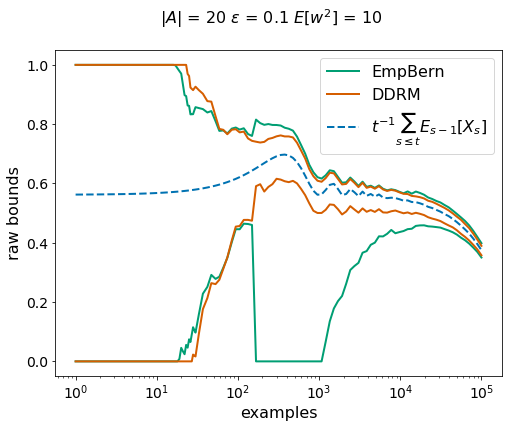

In [5]:
def megasim(*, T, datagen, tau=1000, pts=100, alpha = 0.05, showwr=False, savefig=None):
    import itertools
    from matplotlib import pyplot as plt
    from math import sin, pi
    import numpy as np
    
    assert int(tau) == tau and tau > 1
    assert int(pts) == pts and pts > 1
    
    strats = { f.__class__.__name__: type('',(object,),{ "impl": f, "lbz": [], "ubz": [] })() for f in [ EmpBern(), DDRM() ] } 
    sumwr = 0
    truemu = 0
    truemuz = []
    wrz = []
    tz = []
    targets = list(reversed(range(T))) if T <= pts else list(reversed(np.geomspace(1, T, num=pts)))
    
    for t in range(T):
        w, r, expOp = datagen.genobs()
        rfac = 3/4 - 1/2 * (t/T) + 1/4 * sin(2 * pi * t / tau)
        r = rfac * r
        truemu += rfac * datagen.truemu
        sumwr += w * r
        for _, cs in strats.items():
            cs.impl.addobs((w, r))

        if t + 1 >= targets[-1]:
            targets.pop()
            tz.append(t + 1)
            wrz.append(sumwr)
            truemuz.append(truemu / (t + 1))
            
            for _, cs in strats.items():
                l, u = cs.impl.getci(alpha=0.05)
                cs.lbz.append(l)
                cs.ubz.append(u)

    plt.style.use('seaborn-colorblind')
    fig, ax = plt.subplots(1, 2 if showwr else 1)
    try:
        ax[0]._get_lines.prop_cycler
    except:
        ax = [ ax ]
    fig.set_size_inches(8 * len(ax), 6)
    for n, (k, cs) in enumerate(strats.items()):
        ax[0].plot(tz, cs.lbz, label=k, color=f'C{n+1}', linewidth=2)
        ax[0].plot(tz, cs.ubz, color=f'C{n+1}', linewidth=2)
    ax[0].plot(tz, truemuz, linestyle='dashed', color=f'C{0}', label='$t^{-1} \sum_{s \\leq t} E_{s-1}[X_s]$', linewidth=2)
    ax[0].set_xlabel(f'examples', fontsize=16)
    ax[0].set_ylabel('raw bounds', fontsize=16)
    ax[0].tick_params(labelsize=14)
    ax[0].set_xscale('log')
    ax[0].legend(fontsize=16)
    if len(ax) > 1:
        ax[1].plot(tz, wrz)
        ax[1].set_xlabel(f'examples')
        ax[1].set_ylabel('sum(wr)')
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        
    fig.suptitle(str(datagen), fontsize=16)
    
    if savefig is not None:
        plt.savefig(savefig)
    
def flass():
    dg = DataGen(A=20, epsilon=1/10, expwsq=10, truemu=3/4, seed=4542)
    megasim(T=100000, datagen=dg, savefig='epsgreedy.pdf')

flass()

# Pareto Simulation
Pareto distributed importance weights with mean 1 and infinite variance.

NB: Empirical Bernstein doesn't have an asymptotic guarantee here since the variance is not finite.

In [6]:
class ParetoDataGen(object):
    def __init__(self, *, q, vpi, seed):
        import numpy as np

        assert 1 < q
        
        dist, vmu, aone, atwo, expOp = self._getparams(q, vpi)
        self.dist = dist
        self.vmu = vmu
        self.aone = aone
        self.atwo = atwo
        self._expOp = expOp
        self._expOpMemo = {}
        
        self.q = q
        self.vpi = vpi
        self.tgen = np.random.default_rng(seed)
        self.seed = seed

    def _getparams(self, q, vpi):
        from math import sqrt
        import numpy as np
        import scipy.integrate as si
        import scipy.optimize as so
        from scipy.stats import pareto
        
        # w under mu is Pareto distributed with shape parameter alpha
        # we need to choose the scale so that E[w]=1
        
        dist = pareto(b=q, scale=(q-1)/q)
                
        # r = a1 + a2 w/(w+1)
        # vmu = a1 + a2 E_mu[w/(w+1)] = a1 + a2 dmu
        # vpi = a1 + a2 E_mu[w^2/(w+1)] = a1 + a2 dpi
        
        dmu = si.quad(lambda w: dist.pdf(w)*w/(w+1), 0, np.inf)[0]
        dpi = si.quad(lambda w: dist.pdf(w)*w**2/(w+1), 0, np.inf)[0]
        
        # minimize aone + atwo * dmu
        # s.t.
        # vpi == aone + atwo * dpi
        # aone >= 0
        # atwo >= 0
        # aone + atwo <= 1
        
        c = [ 1, dmu ]
        A_eq = [ [ 1, dpi ] ]
        b_eq = [ vpi ]
        A_ub = [ [ 1, 1 ] ]
        b_ub = [ 1 ]
        
        res = so.linprog(np.array(c), A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=[(0, None), (0, None)])
        assert res.success, res
        aone, atwo = res.x
        vmu = res.fun
        
        expOp = lambda func: si.quad(lambda w: dist.pdf(w) * func(w), 0, np.inf)[0] 
        
        return dist, vmu, aone, atwo, expOp
    
    def _memoexpOp(self, func):
        if func not in self._expOpMemo:
            self._expOpMemo[func] = self._expOp(func)
        return self._expOpMemo[func]
    
    def genobs(self):
        w = self.dist.rvs(random_state=self.tgen)
        r = self.aone + self.atwo * w / (w + 1)
        assert 0 <= r <= 1, r
        return w, r, lambda func: self._memoexpOp(func)
    
    def __str__(self):
        import scipy.optimize as so
        
        shape = self.q
        scale = (self.q - 1) / self.q
        target = 2
        
        res = so.root_scalar(f = lambda m: scale**m * shape / (shape - m) - target,  
                             method = 'brentq',
                             bracket = [ 1, shape - 1/100 ])
        assert res.converged, res

        nicemom = res.root
        nicemomval = scale**(nicemom) * shape / (shape - nicemom)
        nicevar = '\\infty' if self.q <= 2 else self.dist.var()
        return f'$p(w) \propto w^{{-{self.q+1}}}$, $E[w^{{{nicemom:.3f}}}] \\approx {target}$, $E[w^2] = {nicevar}$'

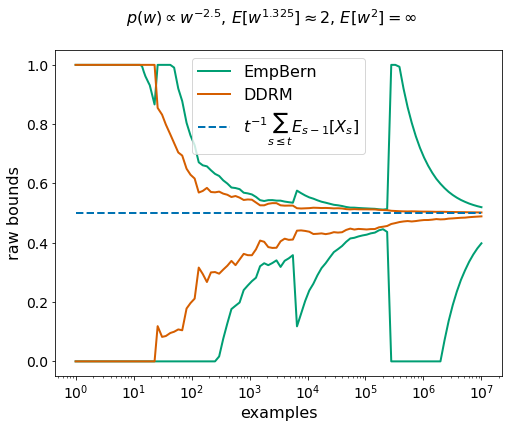

In [7]:
def ultrasim(*, T, datagen, pts=100, alpha = 0.05, showwr=False, savefig=None):
    import itertools
    from matplotlib import pyplot as plt 
    import numpy as np
    
    strats = { f.__class__.__name__: type('',(object,),{ "impl": f, "lbz": [], "ubz": [] })() for f in [ EmpBern(), DDRM() ] } 
    wrz = []
    sumwrz = 0
    tz = []
    targets = list(reversed(range(T))) if T <= pts else list(reversed(np.geomspace(1, T, num=pts)))
    
    for t in range(T):
        w, r, expOp = datagen.genobs()
        for _, cs in strats.items():
            cs.impl.addobs((w, r))
        sumwrz += w * r
        
        if t + 1 >= targets[-1]:
            targets.pop()
            tz.append(t + 1)
            wrz.append(sumwrz)

            for _, cs in strats.items():
                l, u = cs.impl.getci(alpha=0.05)
                cs.lbz.append(l)
                cs.ubz.append(u)
        
    plt.style.use('seaborn-colorblind')
    fig, ax = plt.subplots(1, 2 if showwr else 1)
    try:
        ax[0]._get_lines.prop_cycler
    except:
        ax = [ ax ]
    fig.set_size_inches(8 * len(ax), 6)
    for n, (k, cs) in enumerate(strats.items()):
        ax[0].plot(tz, cs.lbz, label=k, color=f'C{n+1}', linewidth=2)
        ax[0].plot(tz, cs.ubz, color=f'C{n+1}', linewidth=2)
    ax[0].plot(tz, [datagen.vpi]*len(cs.lbz), linestyle='dashed', color=f'C{0}', label='$t^{-1} \sum_{s \leq t} E_{s-1}[X_s]$', linewidth=2)
    ax[0].set_xlabel(f'examples', fontsize=16)
    ax[0].set_ylabel('raw bounds', fontsize=16)
    ax[0].tick_params(labelsize=14)
    ax[0].set_xscale('log')
    ax[0].legend(fontsize=16)
    
    if len(ax) > 1:
        ax[1].plot(tz, wrz)
        ax[1].set_xlabel(f'examples')
        ax[1].set_ylabel('sum(wr)')
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        
    fig.suptitle(str(datagen), fontsize=16)
    
    if savefig is not None:
        plt.savefig(savefig)

def flass():
    dg = ParetoDataGen(q=1.5, vpi=1/2, seed=4552)
    ultrasim(T=10000000, datagen=dg, savefig='pareto.pdf')

flass()